In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import movie_data as md
import importlib
%matplotlib inline

In [105]:
full_df = md.generate_movie_analysis_df()


Importing tables into dataframes...
Cleaning data...
Merging IMDB data...
Merging BoxOfficeMojo data...
Merging TheNumbers data...
Calculating profit and ROI


In [106]:
df = full_df
df=df.head()

In [14]:
df.describe()

,start_year,runtime_minutes,averagerating,numvotes,year,production_budget,domestic_gross,worldwide_gross,profit,roi
count,1135.000000,1135.000000,1134.000000,1.134000e+03,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000
mean,2013.579736,109.335683,6.472928,1.387685e+05,2013.663436,49.292330,64.145831,161.681521,112.389190,3.514366
std,2.511092,17.613655,0.930022,1.729823e+05,2.509142,57.440479,87.358082,243.021924,201.431578,13.954478
min,2010.000000,41.000000,1.600000,1.000000e+01,2010.000000,0.050000,0.000000,0.001242,-110.450242,-0.999862
25%,2011.000000,97.000000,5.900000,3.483400e+04,2011.000000,11.000000,9.934055,20.968331,3.920029,0.240090
50%,2013.000000,106.000000,6.500000,8.087400e+04,2014.000000,28.000000,35.593113,70.536870,36.118378,1.493783
75%,2016.000000,119.000000,7.100000,1.698302e+05,2016.000000,60.000000,79.145948,186.798798,124.707235,3.405503
max,2018.000000,180.000000,8.800000,1.841066e+06,2018.000000,410.600000,700.059566,2048.134200,1748.134200,415.564740


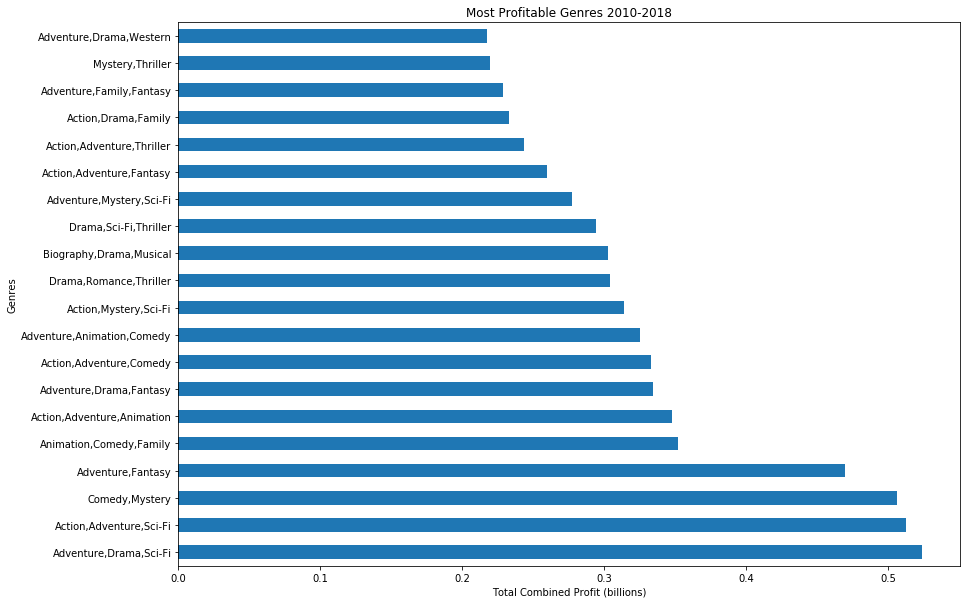

In [15]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').sum().sort_values(ascending=False, 
                                                   by='profit')['profit'][:20].div(1000).plot.barh()

ax.set_xlabel('Total Combined Profit (billions)')
ax.set_ylabel('Genres')
ax.set_title('Most Profitable Genres 2010-2018');


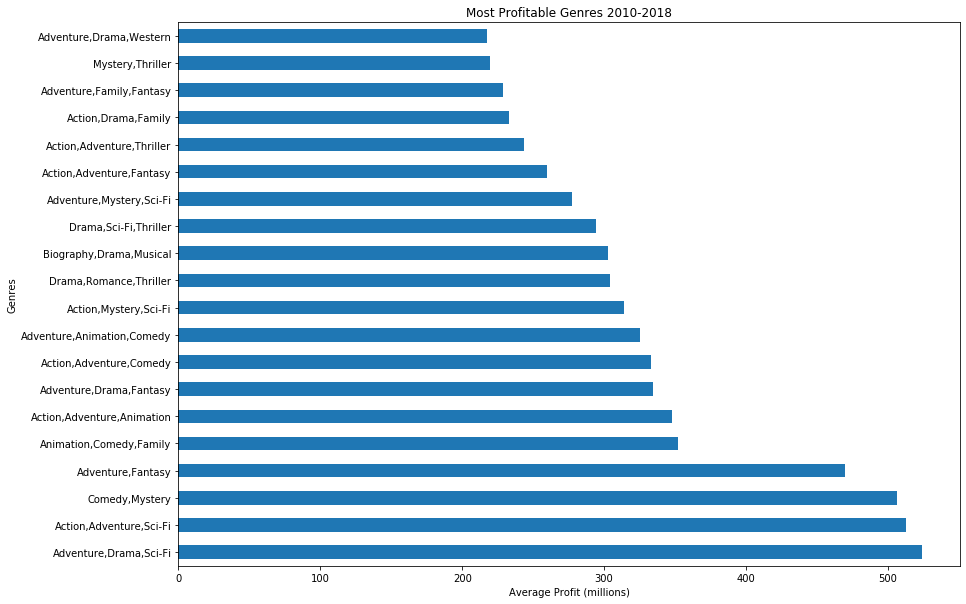

In [16]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').mean().sort_values(ascending=False, 
                                                   by='profit')['profit'][:20].plot.barh()

ax.set_xlabel('Average Profit (millions)')
ax.set_ylabel('Genres')
ax.set_title('Most Profitable Genres 2010-2018');

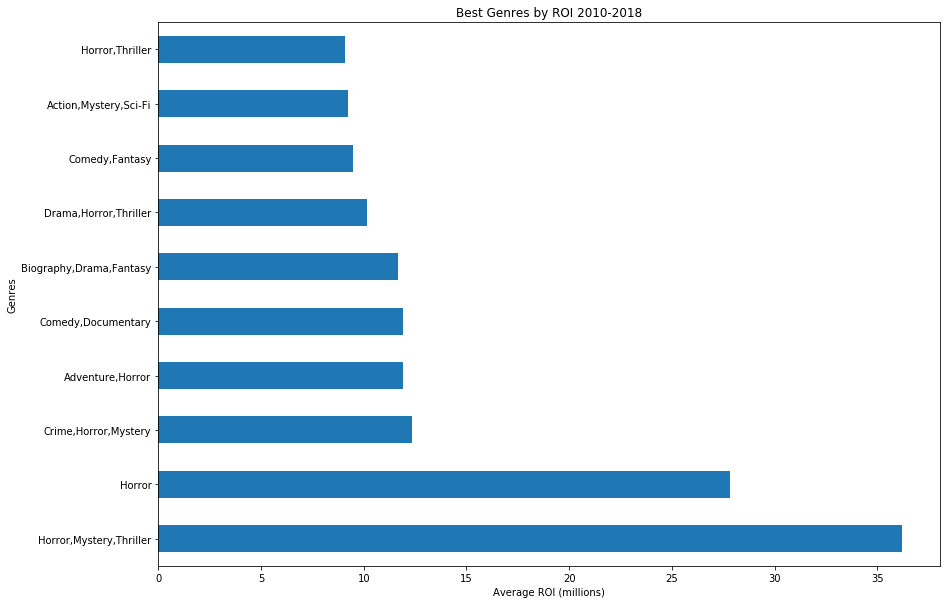

In [18]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

df.groupby('genres').mean().sort_values(ascending=False, 
                                                   by='roi')['roi'][:10].plot.barh()

ax.set_xlabel('Average ROI (millions)')
ax.set_ylabel('Genres')
ax.set_title('Best Genres by ROI 2010-2018');

In [52]:
top10_roi_genres = df.groupby('genres').mean().sort_values(ascending=False, 
                                                   by='roi')[:30]

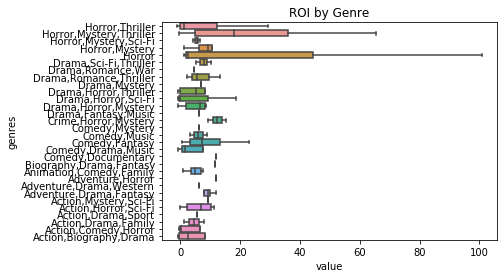

In [53]:
df_long = pd.melt(df, id_vars =['genres'], value_vars =['roi'])
df_long = df_long[df_long['genres'].isin(top10_roi_genres.index)]\
    .sort_values(ascending=False, by='genres')
roi_by_genre = sns.boxplot(data=df_long, x='value', y='genres', showfliers=False)
roi_by_genre.set_title('ROI by Genre');

# Break out genres into separate flags

In [33]:
list_df = df.copy()
from split_data_fields import multifield_to_list
list_df = multifield_to_list(list_df,'genres')

In [47]:
list_df['is_horror'] = list_df['genres'].apply(lambda x: 'Horror' in set(x))

In [48]:
list_df

,title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,studio,year,release_date,production_budget,domestic_gross,worldwide_gross,profit,roi,is_horror
tconst,,,,,,,,,,,,,,,,
tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"[Drama, Horror, Mystery]",7.2,260383.0,Par.,2016,2016-03-11,5.00,72.082999,108.286422,103.286422,20.657284,True
tt1413492,12 Strong,12 Strong,2018,130.0,"[Action, Drama, History]",6.6,50155.0,WB,2018,2018-01-19,35.00,45.819713,71.118378,36.118378,1.031954,False
tt2024544,12 Years a Slave,12 Years a Slave,2013,134.0,"[Biography, Drama, History]",8.1,577301.0,FoxS,2013,2013-10-18,20.00,56.671993,181.025343,161.025343,8.051267,False
tt1542344,127 Hours,127 Hours,2010,94.0,"[Adventure, Biography, Drama]",7.6,323949.0,FoxS,2010,2010-11-05,18.00,18.335230,60.217171,42.217171,2.345398,False
tt2059171,13 Sins,13 Sins,2014,93.0,"[Horror, Thriller]",6.3,29550.0,RTWC,2014,2014-04-18,4.00,0.009134,0.047552,-3.952448,-0.988112,True
tt1272878,2 Guns,2 Guns,2013,109.0,"[Action, Comedy, Crime]",6.7,182025.0,Uni.,2013,2013-08-02,61.00,75.612460,132.493015,71.493015,1.172017,False
tt1232829,21 Jump Street,21 Jump Street,2012,109.0,"[Action, Comedy, Crime]",7.2,477771.0,Sony,2012,2012-03-16,42.00,138.447667,202.812429,160.812429,3.828867,False
tt2294449,22 Jump Street,22 Jump Street,2014,112.0,"[Action, Comedy, Crime]",7.0,319504.0,Sony,2014,2014-06-13,50.00,191.719337,331.333876,281.333876,5.626678,False
tt2172934,3 Days to Kill,3 Days to Kill,2014,117.0,"[Action, Drama, Thriller]",6.2,81681.0,Rela.,2014,2014-02-21,28.00,30.697999,38.959900,10.959900,0.391425,False


In [49]:
list_df['is_adventure'] = list_df['genres'].apply(lambda x: 'Adventure' in set(x))

In [50]:
list_df['is_comedy'] = list_df['genres'].apply(lambda x: 'Comedy' in set(x))

In [51]:
list_df['is_drama'] = list_df['genres'].apply(lambda x: 'Drama' in set(x))

In [54]:
list_df['is_action'] = list_df['genres'].apply(lambda x: 'Action' in set(x))

In [55]:
list_df['is_biography'] = list_df['genres'].apply(lambda x: 'Biography' in set(x))

In [57]:
list_df.head()

,title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,studio,year,release_date,...,domestic_gross,worldwide_gross,profit,roi,is_horror,is_adventure,is_comedy,is_drama,is_action,is_biography
tconst,,,,,,,,,,,,,,,,,,,,,
tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"[Drama, Horror, Mystery]",7.2,260383.0,Par.,2016,2016-03-11,...,72.082999,108.286422,103.286422,20.657284,True,False,False,True,False,False
tt1413492,12 Strong,12 Strong,2018,130.0,"[Action, Drama, History]",6.6,50155.0,WB,2018,2018-01-19,...,45.819713,71.118378,36.118378,1.031954,False,False,False,True,True,False
tt2024544,12 Years a Slave,12 Years a Slave,2013,134.0,"[Biography, Drama, History]",8.1,577301.0,FoxS,2013,2013-10-18,...,56.671993,181.025343,161.025343,8.051267,False,False,False,True,False,True
tt1542344,127 Hours,127 Hours,2010,94.0,"[Adventure, Biography, Drama]",7.6,323949.0,FoxS,2010,2010-11-05,...,18.335230,60.217171,42.217171,2.345398,False,True,False,True,False,True
tt2059171,13 Sins,13 Sins,2014,93.0,"[Horror, Thriller]",6.3,29550.0,RTWC,2014,2014-04-18,...,0.009134,0.047552,-3.952448,-0.988112,True,False,False,False,False,False


In [58]:
df_long = pd.melt(df, id_vars =['genres'], value_vars =['roi'])

# Break out genres into separate rows

In [61]:
from split_data_fields import multifield_to_col
expand_df = multifield_to_col(df, 'tconst', 'genres')

In [89]:
top30_roi_genre = expand_df.groupby('genre').median().sort_values(ascending=False, 
                                                   by='roi')[:30]

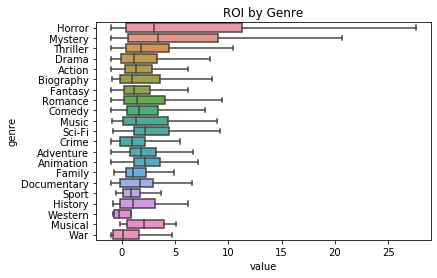

In [99]:
df_long = pd.melt(expand_df, id_vars =['genre'], value_vars =['roi'])
df_long = df_long[df_long['genre'].isin(top30_roi_genre.index)]\
    .sort_values(ascending=False, by='value')
roi_by_genre = sns.boxplot(data=df_long, x='value', y='genre', showfliers=False)
roi_by_genre.set_title('ROI by Genre');

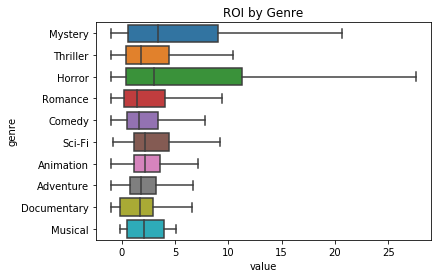

In [91]:
top10_roi_genre = expand_df.groupby('genre').median().sort_values(ascending=False, 
                                                   by='roi')[:10]
df_long = pd.melt(expand_df, id_vars =['genre'], value_vars =['roi'])
df_long = df_long[df_long['genre'].isin(top10_roi_genre.index)]\
    .sort_values(ascending=False, by='value')
roi_by_genre = sns.boxplot(data=df_long, x='value', y='genre', showfliers=False)
roi_by_genre.set_title('ROI by Genre');

In [104]:
df[df.genres=='Horror,Mystery,Thriller'][['title','roi']]

,title,roi
tconst,,
tt3322940,Annabelle,38.517372
tt5140878,Annabelle: Creation,19.358991
tt1540011,Blair Witch,2.898558
tt1991245,Chernobyl Diaries,41.411721
tt1314655,Devil,5.335411
tt2752758,Devil's Due,4.163727
tt5052448,Get Out,50.073590
tt5308322,Happy Death Day,24.002052
tt1591095,Insidious,65.580591


In [122]:
df = full_df.reset_index()
df

,tconst,title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,studio,year,release_date,production_budget,domestic_gross,worldwide_gross,profit,roi
0,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery",7.2,260383.0,Par.,2016,2016-03-11,5.00,72.082999,108.286422,103.286422,20.657284
1,tt1413492,12 Strong,12 Strong,2018,130.0,"Action,Drama,History",6.6,50155.0,WB,2018,2018-01-19,35.00,45.819713,71.118378,36.118378,1.031954
2,tt2024544,12 Years a Slave,12 Years a Slave,2013,134.0,"Biography,Drama,History",8.1,577301.0,FoxS,2013,2013-10-18,20.00,56.671993,181.025343,161.025343,8.051267
3,tt1542344,127 Hours,127 Hours,2010,94.0,"Adventure,Biography,Drama",7.6,323949.0,FoxS,2010,2010-11-05,18.00,18.335230,60.217171,42.217171,2.345398
4,tt2059171,13 Sins,13 Sins,2014,93.0,"Horror,Thriller",6.3,29550.0,RTWC,2014,2014-04-18,4.00,0.009134,0.047552,-3.952448,-0.988112
5,tt1272878,2 Guns,2 Guns,2013,109.0,"Action,Comedy,Crime",6.7,182025.0,Uni.,2013,2013-08-02,61.00,75.612460,132.493015,71.493015,1.172017
6,tt1232829,21 Jump Street,21 Jump Street,2012,109.0,"Action,Comedy,Crime",7.2,477771.0,Sony,2012,2012-03-16,42.00,138.447667,202.812429,160.812429,3.828867
7,tt2294449,22 Jump Street,22 Jump Street,2014,112.0,"Action,Comedy,Crime",7.0,319504.0,Sony,2014,2014-06-13,50.00,191.719337,331.333876,281.333876,5.626678
8,tt2172934,3 Days to Kill,3 Days to Kill,2014,117.0,"Action,Drama,Thriller",6.2,81681.0,Rela.,2014,2014-02-21,28.00,30.697999,38.959900,10.959900,0.391425
9,tt1622547,30 Minutes or Less,30 Minutes or Less,2011,83.0,"Action,Comedy,Crime",6.1,87254.0,Sony,2011,2011-08-12,28.00,37.053924,40.966716,12.966716,0.463097
